## Добро пожаловать в интерактивный сервис по поиску, классификации и визуализации аномалий.
### Для начала работы, последовательно выполните ячейки среды JupiterNotebook

#### Загрузка пользовательских данных

In [177]:
import pandas as pd
import numpy as np
import seaborn as sns
import pathlib

# Вспомогательная функция вычисления для КОНКРЕТНЫХ ВЛАДЕЛЬЦЕВ ГРУПП СУДОВ, по FishID
def calculatingSummOfFishTransfering(fish_name, start, end):
    print('Processing transfering')
    total_owners = []
    total_transfers = []
    total_fishery_date = []
    total_vsd_date = []
    
    # Смотрю по каждому ID акты передачи    
    vsd_fish_id = ext2[ext2['fish'] == fish_name]['id_vsd']
    # Для каждого акта определяю владельца     
    for vsd in vsd_fish_id:
        owners = ext1[ext1['id_vsd'] == vsd]['id_own'].unique().tolist()
        # Проверяю является ли владелец связанным по двум базам  
        for owner in owners:
            if owner in market_owners:
                data = ext2[ext2['id_vsd'] == vsd]
                try:
                    total_owners.append(owner)
                    total_transfers.append(data['volume'].values[0])
                    total_fishery_date.append(data['date_vsd'].values[0][5:10])
                    total_vsd_date.append(ext1[ext1['id_vsd'] == vsd]['date_fishery'].values[0][5:10])
                except Exception() as e:
                    print(e)
                    
    df = pd.DataFrame()
    
    df['owner'] = total_owners
    df['volume'] = total_transfers
    df['fishery_date'] = total_fishery_date
    df['vsd_date'] = total_vsd_date
    
    return df

# Сводная таблица по всем поступлениям согласно IdFish и выбранного промежутка времени.
def calculatingSummOfFish(fish_name, date_start, date_end):
    print('Processing incoming values')
    # смотрим по всем выловам этой рыбы
    data = catch_df[catch_df['fish'] == fish_name]
    # уникальные номера кораблей ловящих только эту рыбу
    ships = list(set(data['id_ves'].to_list()))
    
    # создаю датафрейм с владельцами и выловом по судам    
    total_df = pd.DataFrame()
    
    total_ships = []
    total_owners = []
    total_catches = []
    
    # добавляем в общую кашу дату и документируем владельцев
    for ship in ships:
        ship_data = data[data['id_ves'] == ship]
        owners = list(set(ship_data['id_own'].to_list()))
        
        for owner in owners:
            ship_owner_data = ship_data[ship_data['id_own'] == owner]
            
            try:
                ship_owner_end_data = ship_owner_data[ship_owner_data['date'] < date_end]
                ship_owner_start_end_data = ship_owner_end_data[ship_owner_end_data['date'] > date_start]
                total_catch = ship_owner_start_end_data['catch_volume'].sum()
            except e:
                print(e)
            
            if total_catch > 0:
                total_catches.append(total_catch)
                total_ships.append(ship)
                total_owners.append(owner)
            
    total_df['total_catches'] = total_catches
    total_df['ship'] = total_ships
    total_df['owner'] = total_owners
    
    return total_df

# Подмена данных + нормализация
def spoofing(id):
    return fish_df[fish_df['id_fish'] == id]['fish'].values[0]

catch_df = 0
product_df = 0

fish_df = 0

ext1 = 0
ext2 = 0    
ref = 0
 
data_folder = input('Введите путь к папке с данными, сохранив исходную архитектуру\n')
path = pathlib.Path(data_folder)
if path.exists():
    if path.is_dir():
        print('Locating sucsessifully')
        db1 = 0
        db2 = 0
        for subpath in path.iterdir():
            if subpath.name == 'db1':
                db1 = subpath
            if subpath.name == 'db2':
                db2 = subpath
                
        # Последовательно получаем данные о вылове и продукции из 1й БД
        for subpath in db1.iterdir():
            if subpath.name == 'catch.csv':
                catch_df = pd.read_csv(subpath, error_bad_lines=False, sep=',')
            if subpath.name == 'product.csv':
                product_df = pd.read_csv(subpath, error_bad_lines=False, sep=',')
            if subpath.name == 'ref':
                ref = subpath
        
        # Находим базу соответвия рыбы и ID        
        for subpath in ref.iterdir():
            if subpath.name == 'fish.csv':
                fish_df = pd.read_csv(subpath, error_bad_lines=False, sep=';')
        
        # Забираем базу передачи.        
        for subpath in db2.iterdir():
            if subpath.name == 'Ext.csv':
                ext1 = pd.read_csv(subpath, error_bad_lines=False, sep=',')
            if subpath.name == 'Ext2.csv':
                ext2 = pd.read_csv(subpath, error_bad_lines=False, sep=',')
        
        catch_df['fish'] = catch_df['id_fish'].apply(spoofing)
        catch_df['catch_volume'] = catch_df['catch_volume']*1000
        
        ext2['date_vsd'] = ext2['date_vsd'].apply(lambda x: x[:10])
        
        print('Загрузка и базовая предобработка успешна! Переходите к следующей ячейке')
        
    else:
        print('Данный файл не является директорией')
else:
    print('Данная ссылка не существует. Попробуйте ещё раз')

catcher_owners = catch_df['id_own'].unique()
traider_owners = ext1['id_own'].unique()

market_owners = []
for owner in traider_owners:
    if owner in catcher_owners:
        market_owners.append(owner)  
        
default_data = (catch_df['date'][0], catch_df['date'][len(catch_df) - 1])
start, end = default_data
    

Введите путь к папке с данными, сохранив исходную архитектуру
C:\Users\zhiti\Documents\GitHub\Fishing-Control\notebooks\data
Locating sucsessifully
Загрузка и базовая предобработка успешна! Переходите к следующей ячейке


#### Поиск аномалий в общем датасете по выбранному морепродукту

Dropdown(description='Рыба: ', options=(('Не определен', 0), ('макруронус', 1), ('Рыбы и морепродукты', 2), ('…

Значений по данной рыбе нет в базе.
Аномалии следующего объема и по дням:
1.26 т., в течении 2022-01-17 дня
4.68 т., в течении 2022-01-20 дня
0.9 т., в течении 2022-01-21 дня
1.998 т., в течении 2022-02-17 дня
1.458 т., в течении 2022-02-22 дня
1.728 т., в течении 2022-03-02 дня


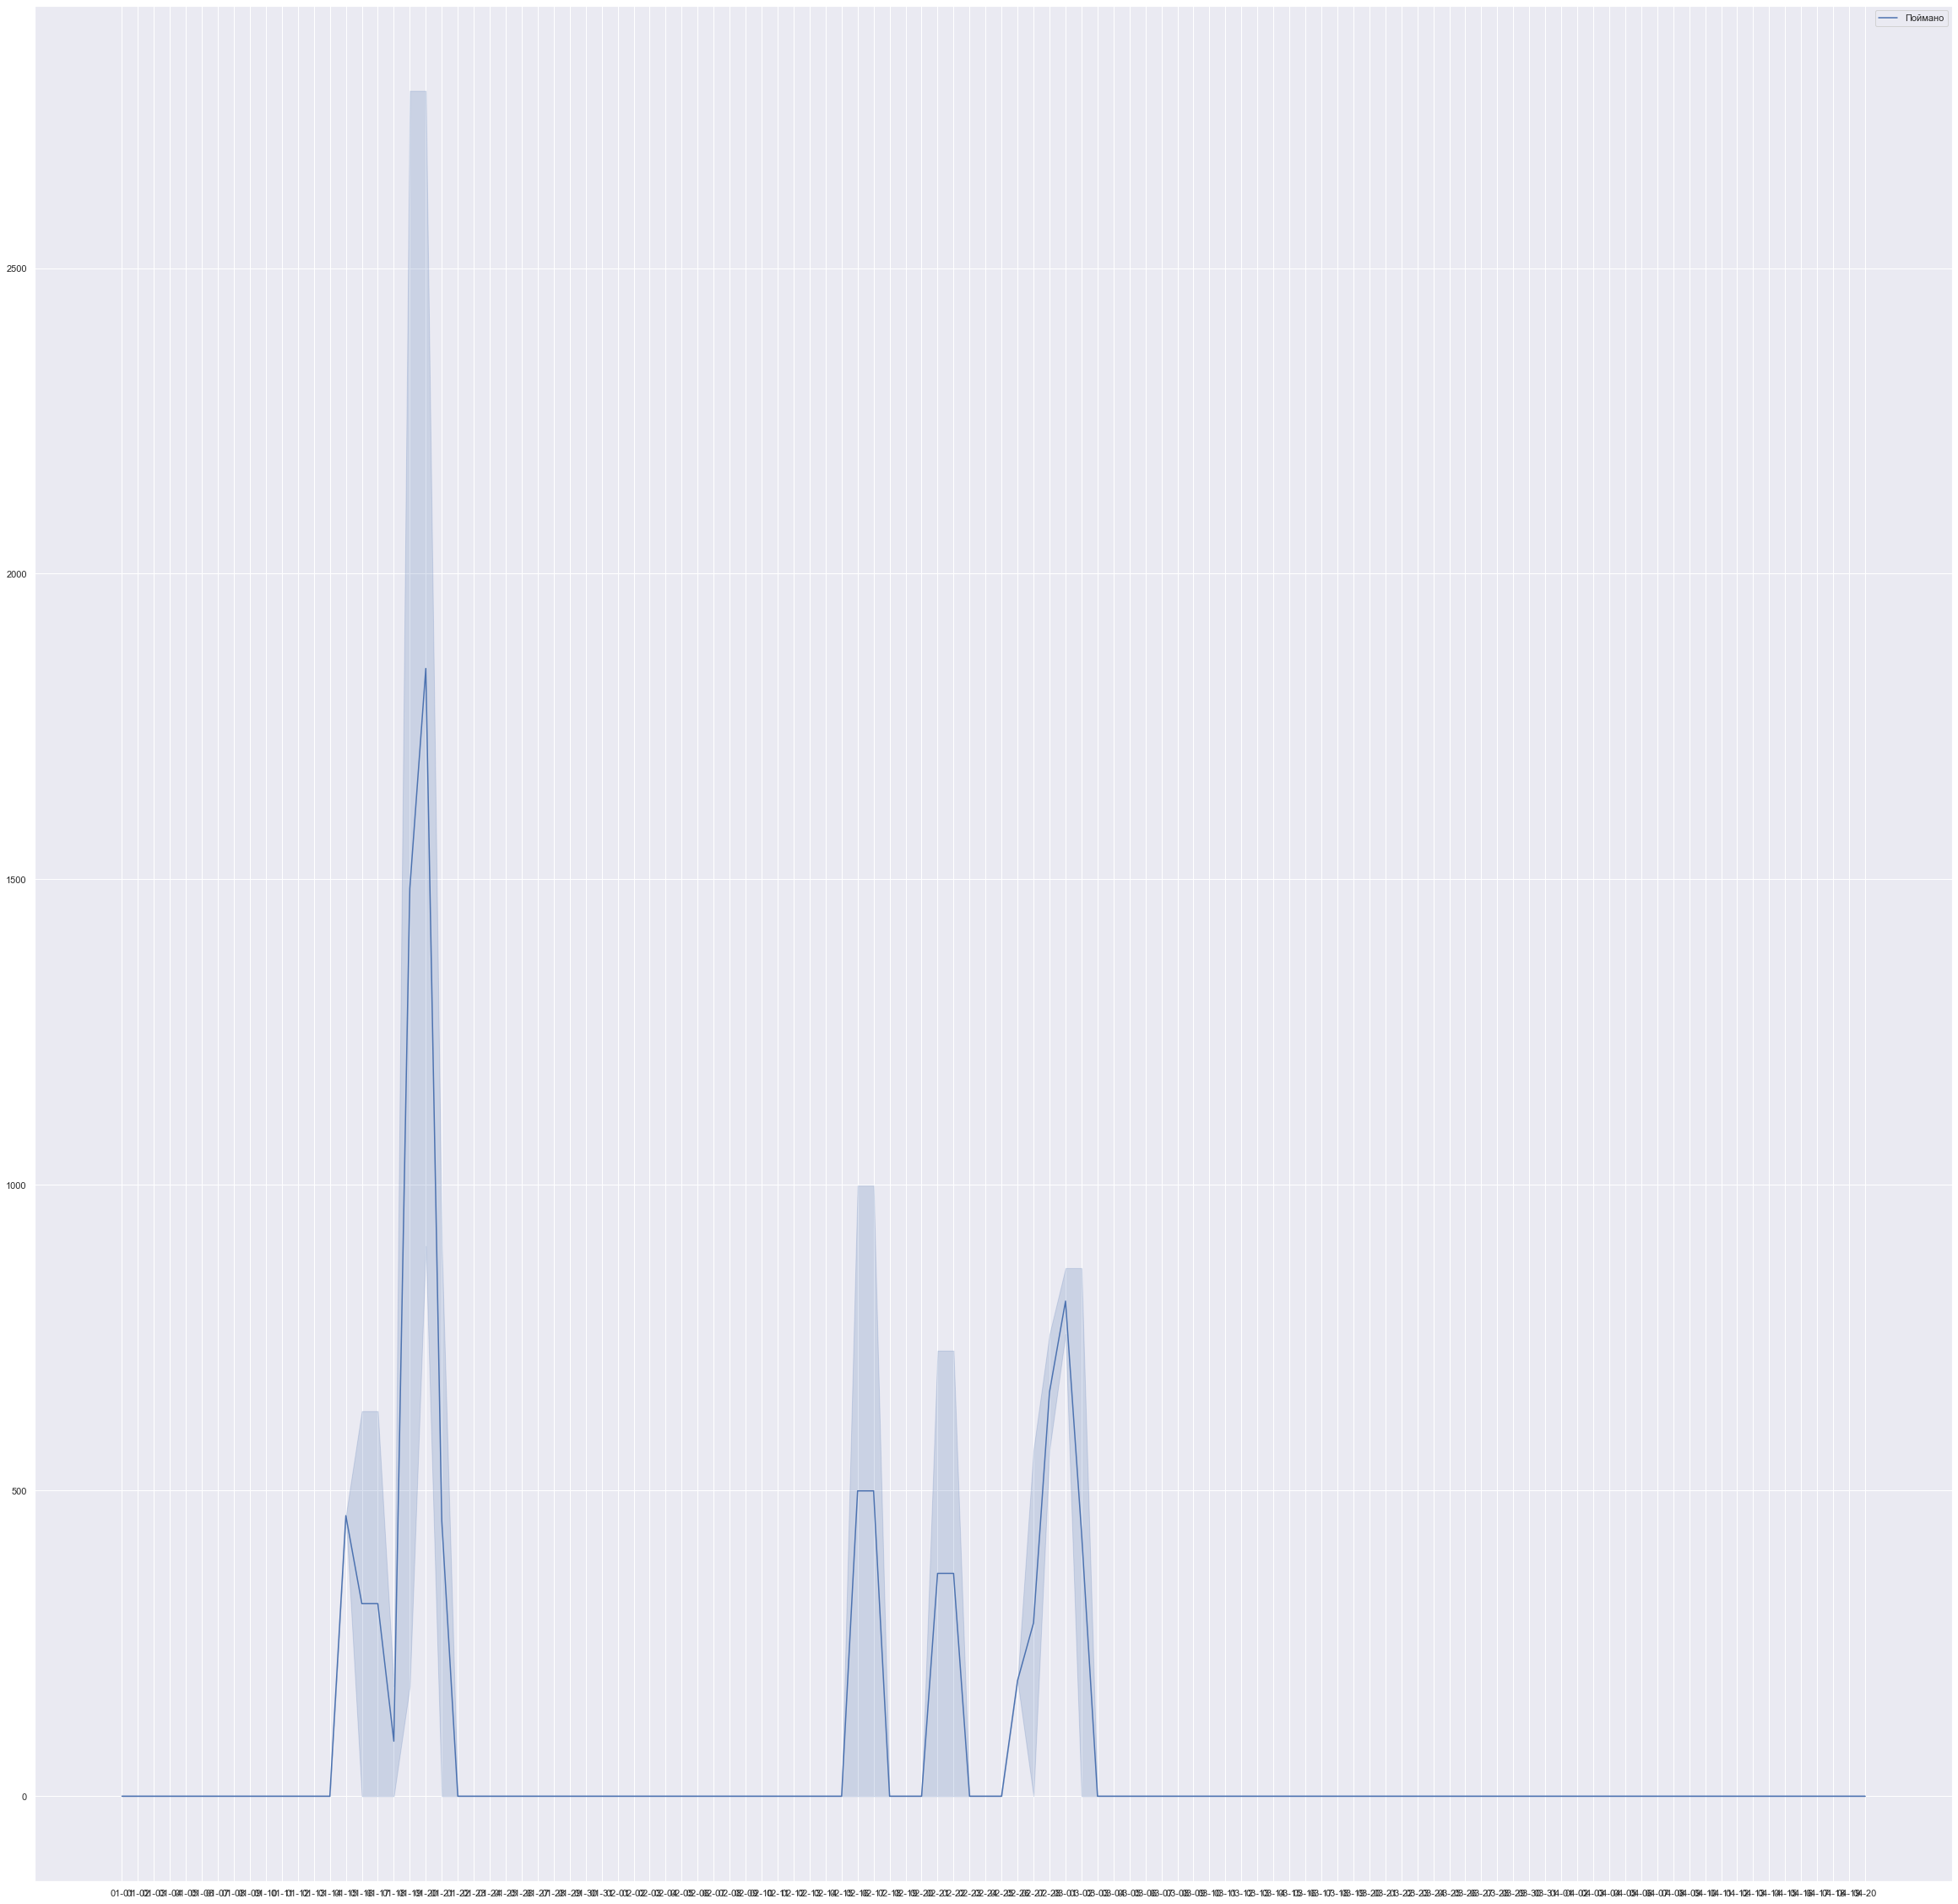

In [178]:
from IPython.display import display
from ipywidgets import Dropdown

fish__ = fish_df['fish'].tolist()
ids__ = fish_df['id_fish'].tolist()

options = []

for index in range(len(ids__)):
    options.append((fish__[index], ids__[index]))
    
dropdown = Dropdown(
    options=options,
    value=0, # Выбор по умолчанию
    description='Рыба: ' 
)

def draw_fish_id_market_anomalies(id_):
    if id_ == -1:
        pass
    else:
        id = id_.new
        dates = catch_df['date'].unique()
        Y = dates.copy()
        Total_X1 = []
        Total_X2 = []

        fish =  fish_df[fish_df['id_fish'] == id]['fish'].values[0]
        X1 = catch_df[catch_df['fish'] == fish]
        X2 = ext2[ext2['fish'] == fish]

        for date in dates:
            X1_dated = X1[X1['date'] == date]['catch_volume'].sum()
            X2_dated = X2[X2['date_vsd'] == date]['volume'].sum()

            Total_X1.append(X1_dated)
            Total_X2.append(X2_dated)
        
        if all([x == 0 for x in Total_X2]) or all([y == 0 for y in Total_X1]):
            print('Значений по данной рыбе нет в базе.')
        else:
            hue = []
            total_x = []
            total_x.extend(Total_X1)
            total_x.extend(Total_X2)
            for x in total_x:
                if x in Total_X1:
                    hue.append('Поймано')
                elif x in Total_X2:
                    hue.append('Передано')
            new_dates = []
            new_dates.extend(dates)
            new_dates.extend(dates)
            new_dates = [x[5:] for x in new_dates]

            sns.lineplot(y=total_x, x=new_dates, hue=hue)
            sns.set(rc={'figure.figsize':(40.7, 40.87)})

            total_anomalies = []
            total_dates = []

            delta_fishery = 0
            for index in range(len(Total_X1)):
                if Total_X1[index] > Total_X2[index]:
                    delta_fishery += Total_X2[index] - Total_X1[index]
                if Total_X1[index] < Total_X2[index]:
                    delta = Total_X2[index] - Total_X1[index]
                    if delta > delta_fishery:
                        total_anomalies.append(int(delta - delta_fishery) / 1000)
                        total_dates.append(dates[index])
                        delta_fishery = 0

            if len(total_anomalies) > 0: 
                print('Аномалии следующего объема и по дням:')
                for index in range(len(total_anomalies)):
                    print(f'{total_anomalies[index] } т., в течении {total_dates[index]} дня')

dropdown.observe(draw_fish_id_market_anomalies, names='value')
display(dropdown)

In [176]:
# Смотрим по общему поступлению владельца и общей передачи
def getAllTransfers(id, start, end):
    incoming = calculatingSummOfFish(id, start, end)
    outcoming = calculatingSummOfFishTransfering(id, start, end)
    # Важно учитывать неналичие в таблице вылова владельцев которые не передают ничего.
    inputs = incoming['owner'].unique().tolist()
    outputs = outcoming['owner'].unique().tolist()
    owners = []
    for item in inputs:
        if item in outputs:
            owners.append(item)

    total_catches = []
    total_transfered = []
    total_owners = []
    total_fish = []
    for owner in owners:
        catch = incoming[incoming['owner'] == owner]['total_catches'].sum()
        transfer = outcoming[outcoming['owner'] == owner]['volume'].sum()
        if catch > 0 or transfer > 0:
            print(len(inputs), len(outputs), len(owners))
            print(catch, transfer, owner)
            total_catches.append(catch)
            total_transfered.append(transfer)
            total_owners.append(owner)
            total_fish.append(id)
    df = pd.DataFrame()
    df['catches'] = total_catches
    df['transfered'] = total_transfered
    df['owner'] = total_owners
    df['fish'] = total_fish
    return df

# Отсюда получаем блок данных в которых достоверно известно о всей получаемой рыбе от владельцев, 
# и о всех их передачах, если они записаны в БД

fishes_id = fish_df['fish'].to_list()[1:]
total_df = getAllTransfers(fishes_id[0], start, end)
for fish in fishes_id[1:]:
    df = getAllTransfers(fish, start, end)
    total_df = total_df.append(df, ignore_index=True)
    total_df
total_df.to_csv('total_transfers.csv')

Processing incoming values
Processing transfering
Processing incoming values
Processing transfering
Processing incoming values
Processing transfering
Processing incoming values
Processing transfering
Processing incoming values
Processing transfering
Processing incoming values
Processing transfering
5 1 1
552645.0 1024891 8608103
Processing incoming values
Processing transfering
Processing incoming values
Processing transfering
Processing incoming values
Processing transfering
Processing incoming values
Processing transfering
Processing incoming values
Processing transfering
Processing incoming values
Processing transfering
Processing incoming values
Processing transfering
1 1 1
9063.0 9063 5258490
Processing incoming values
Processing transfering
Processing incoming values
Processing transfering
Processing incoming values
Processing transfering


KeyboardInterrupt: 

### Инструмент для получения аномалий по транзитивным отношениям владельцев групп суден для нахождения нарушителей по конкретному морепродукту

Dropdown(description='Рыба:', options=('шпрот (килька)', 'тунцы'), value='шпрот (килька)')

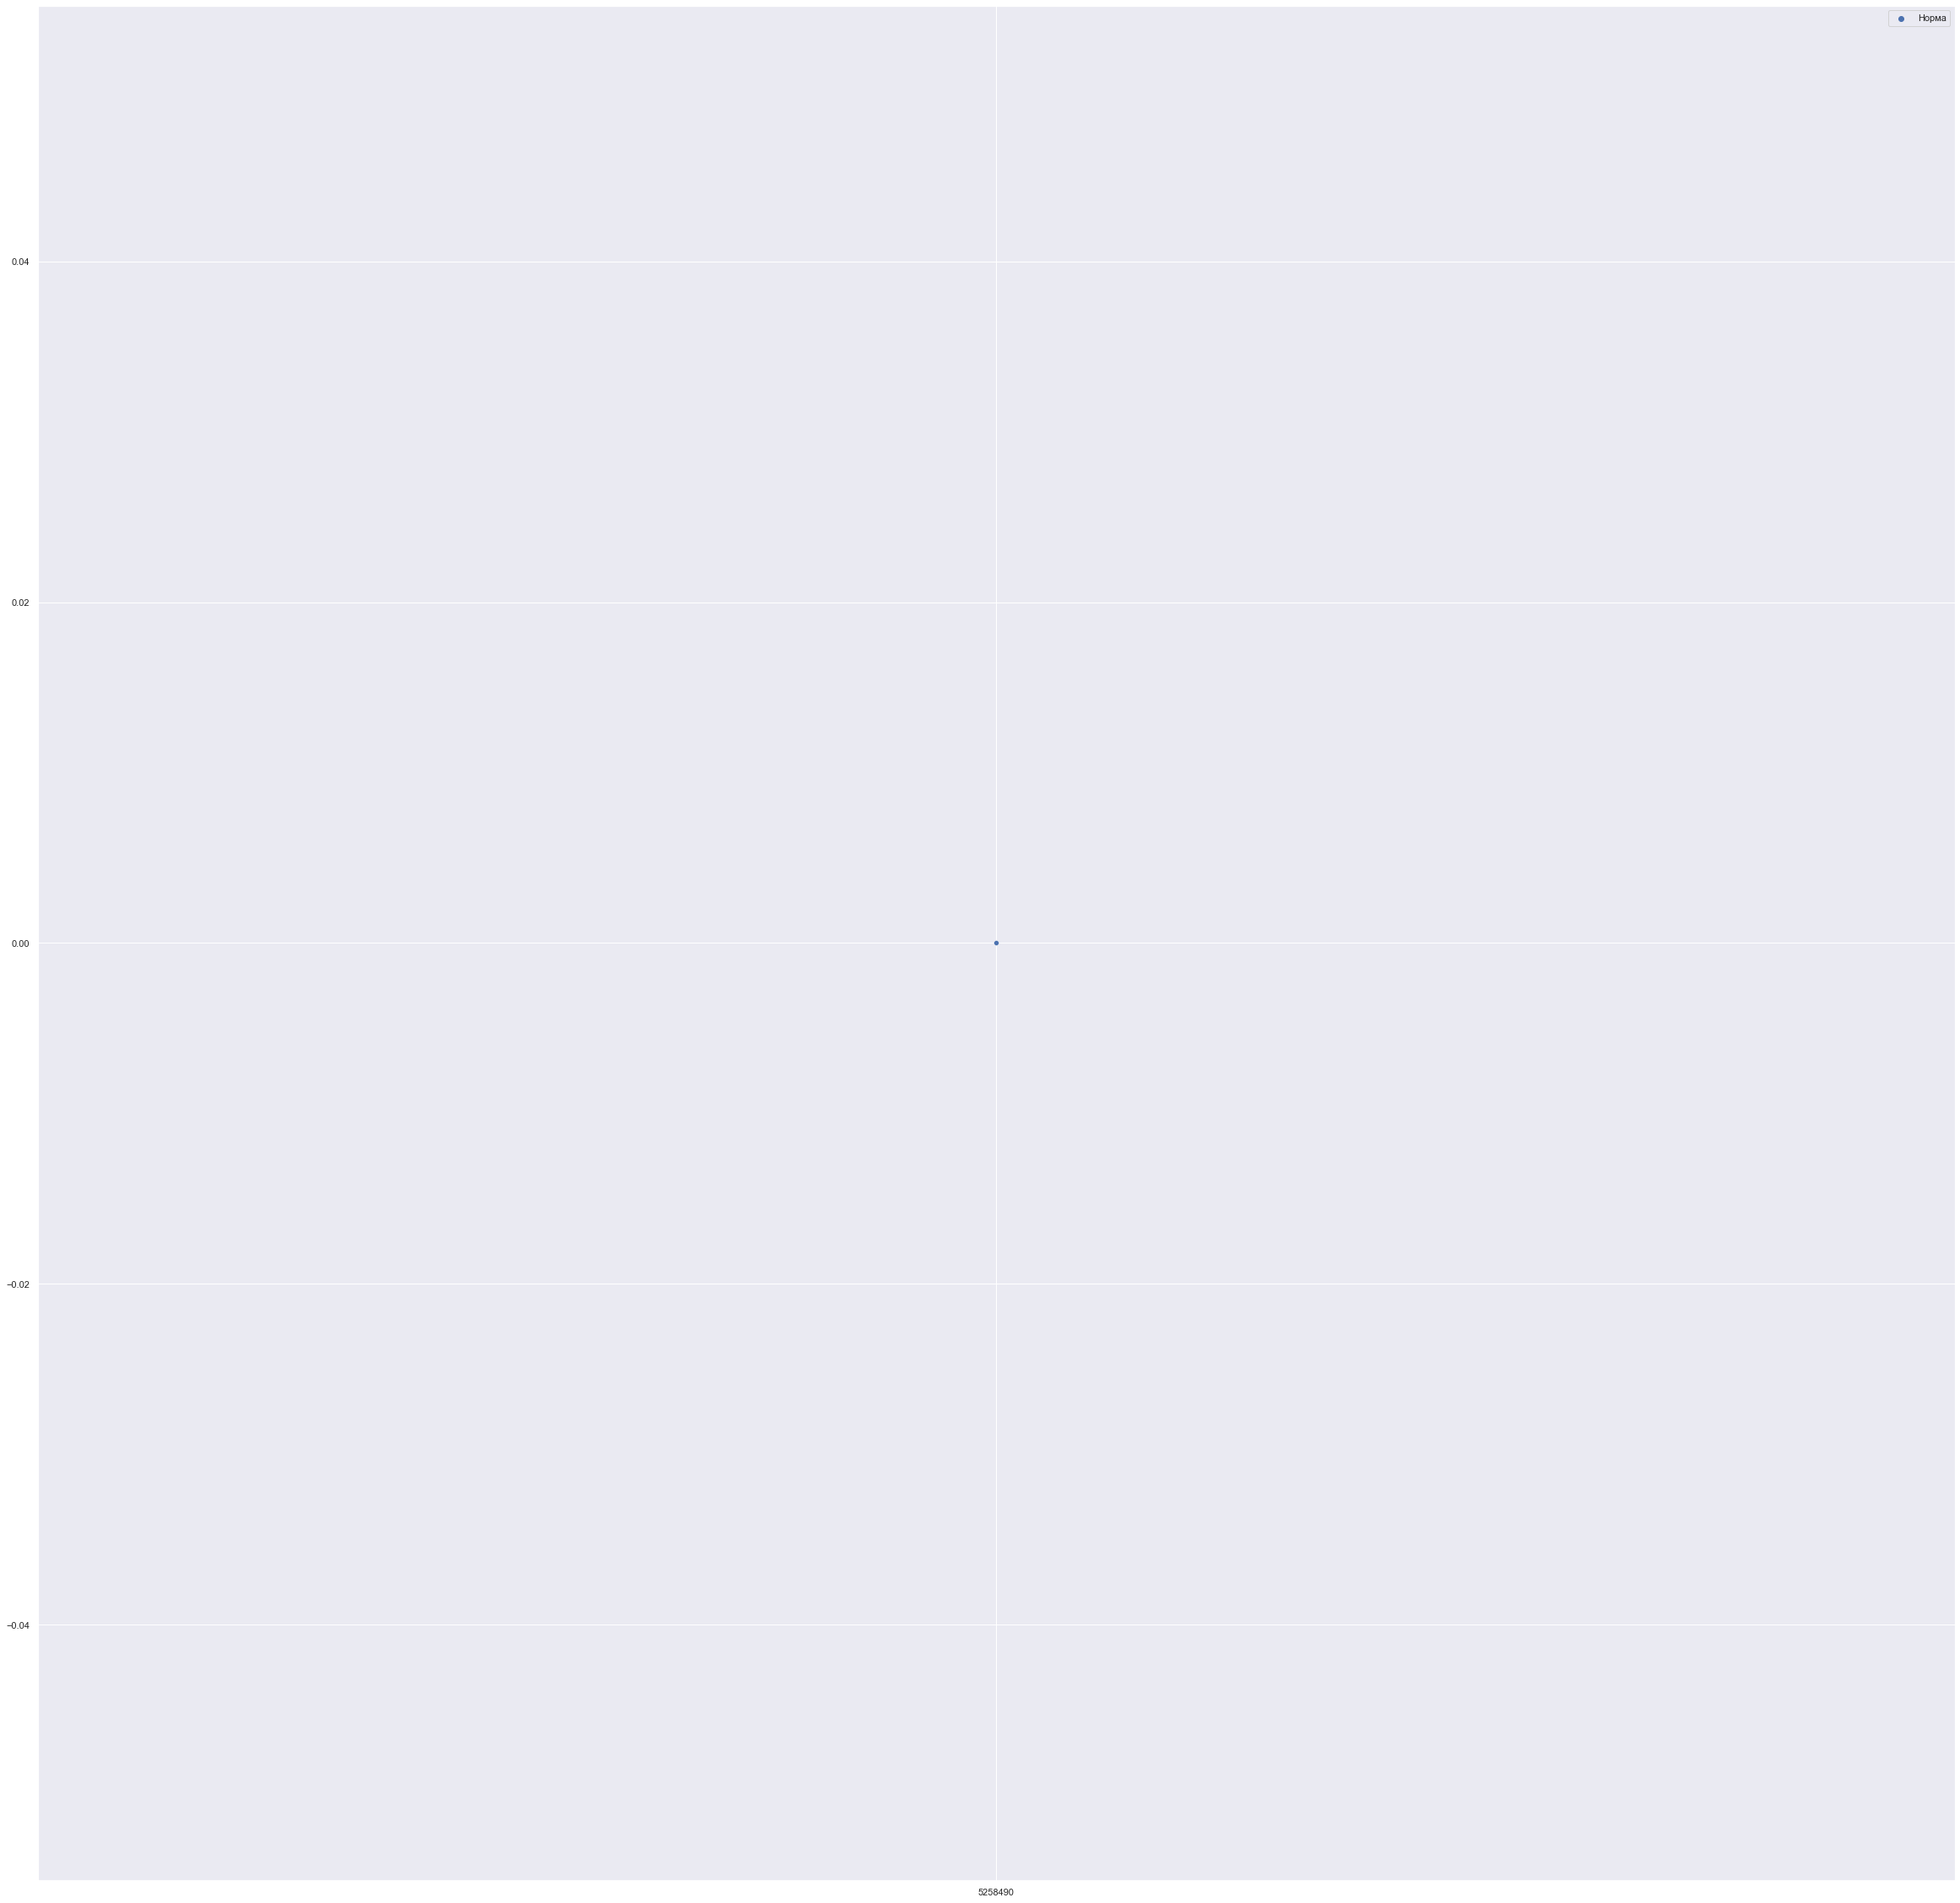

In [179]:
from IPython.display import display
from ipywidgets import Dropdown

fishes_list = total_df['fish'].unique().tolist()

drop1 = Dropdown(
    options = fishes_list,
    description = 'Рыба:'
)

def on_button_click(fish):
    target = fish.new
    total_df['delta'] = total_df['transfered'] - total_df['catches']

    current_owners = total_df[total_df['fish'] == target]['owner'].tolist()
    current_delta = total_df[total_df['fish'] == target]['delta'].tolist()
    current_catches = total_df[total_df['fish'] == target]['catches'].tolist()
    hue_ = []

    for index in range(len(current_delta)):
        if current_delta[index] <= 0: 
            hue_.append('Норма')
        # Допустимое отклонение от нормы согласно нормальному закону распределения         
        elif current_delta[index] < current_catches[index] * 12 / 100:
            hue_.append('Норма')
        else:
            hue_.append('Аномалия')

    current_owners = [str(int(x)) for x in current_owners]
    sns.scatterplot(x=current_owners, y=current_delta, hue=hue_)
    sns.set(rc={'figure.figsize':(41.7,8.47)})

    for index in range(len(current_owners)):
        if hue_[index] == 'Аномалия':
            print(f'Владелец группы судов (ID - {current_owners[index]}) - передал больше, чем выловил за весь период.\nПревышение составило - {current_delta[index]} т.')

drop1.observe(on_button_click, names='value')
display(drop1)

### Инструмент нахождения всех аномалий в первой и второй базе, таргетированных по владельцу и рыбе

In [169]:
total_df['delta'] = total_df['transfered'] - total_df['catches']

fishes_ = total_df['fish'].tolist()
owners_ = total_df['owner'].tolist()
delta_ = total_df['delta'].tolist()
catches_ = total_df['catches'].tolist()

for index in range(len(owners_)):
    if delta_[index] <= 0 or delta_[index] < catches_[index] * 12 / 100:
        pass
    else:
        print(f'Владелец (ID - {str(int(owners_[index]))}) превысил норму вылова БВР {fishes_[index]} на {delta_[index]} т.')

Владелец (ID - 8608103) превысил норму вылова БВР шпрот (килька) на 472246.0 т.
Владелец (ID - 8205073) превысил норму вылова БВР окунь-клювач на 16728.0 т.
Владелец (ID - 2747448) превысил норму вылова БВР окунь-клювач на 7173.0 т.
Владелец (ID - 1921181) превысил норму вылова БВР окунь-клювач на 59598.0 т.
Владелец (ID - 6885089) превысил норму вылова БВР окунь-клювач на 283878.0 т.
Владелец (ID - 7656004) превысил норму вылова БВР окунь-клювач на 722424.45 т.
Владелец (ID - 7372847) превысил норму вылова БВР окунь-клювач на 336244.0 т.
Владелец (ID - 4149660) превысил норму вылова БВР окунь-клювач на 41089.0 т.
Владелец (ID - 9407225) превысил норму вылова БВР окунь-клювач на 33907.486000000004 т.
Владелец (ID - 1642654) превысил норму вылова БВР окунь-клювач на 3455.0 т.
Владелец (ID - 8090733) превысил норму вылова БВР окунь-клювач на 346839.0 т.
Владелец (ID - 4760527) превысил норму вылова БВР окунь-клювач на 431841.0 т.
Владелец (ID - 78422) превысил норму вылова БВР окунь-клюв

### Инструмент проверки вылова согласно лицензиям по кораблям (если будут даны лицензии)

In [180]:
import plotly.express as px
import plotly.graph_objects as go

from ipywidgets import Button, DatePicker, Layout

def calculatingSummOfFishforOwner(owner_id, date_start, date_end):
    # смотрим по конкретному владельцу
    data = catch_df[catch_df['id_own'] == owner_id]
    
    # уникальные номера кораблей ловящих только эту рыбу
    ships = list(set(data['id_ves'].to_list()))
    permits = list(set(data['permit'].to_list()))
    # создаю датафрейм с владельцами и выловом по судам    
    total_df = pd.DataFrame()
    
    total_ships = []
    total_owners = []
    total_catches = []
    total_fish = []
    total_permits = []
    
    # добавляем в общую кашу дату и документируем владельцев
    for ship in ships:
        ship_data = data[data['id_ves'] == ship]
        fishes = list(set(ship_data['fish'].to_list()))
        permits = list(set(ship_data['permit'].to_list()))
        for fish in fishes:
            ship_fish_data = ship_data[ship_data['fish'] == fish]
            for permit in permits:
                ship_permit_data = ship_data[ship_data['permit'] == permit]
            try:
                ship_fish_end_data = ship_fish_data[ship_fish_data['date'] < date_end]
                ship_fish_start_end_data = ship_fish_end_data[ship_fish_end_data['date'] > date_start]
                total_catch = ship_fish_start_end_data['catch_volume'].sum()
            except:
                print('По данным датам владелец не вылавливал согласно базам данных')
                return 0
            
            if total_catch > 0:
                total_catches.append(total_catch)
                total_ships.append(ship)
                total_owners.append(owner_id)
                total_fish.append(fish)
                total_permits.append(permit)
                
    total_df['total_catches'] = total_catches
    total_df['ship'] = total_ships
    total_df['owner'] = total_owners
    total_df['fish'] = total_fish
    total_df['permit'] = total_permits
    
#     total_df['date_start'] = date_start
#     total_df['date_end'] = date_end
#     owner_df = total_df.drop(columns='owner')
    total_df['ship'] = total_df['ship'].apply(lambda x: str(x))
#     owner_df = owner_df.groupby(['fish']).sum()
    fig = px.bar(total_df, x=total_df['ship'], y="total_catches", color=total_df.fish, title=f'Объем вылова морских ресурсов компании id={str(owner_id)} с {date_start} по {date_end} ')
    fig.show()
    
    fig2 = go.Figure(data=[go.Table(header=dict(values=['ID судна', 'Номер разрешения']),
                     cells=dict(values=[total_df.ship.to_list(), total_df.permit.to_list()]))
                         ])
    fig2.show()
    
datepicker1 = DatePicker(
    description='Начало',
    value = datetime.date.fromisoformat('2022-01-01'),
    disabled=False,
    layout=Layout(width='50%', height='20px')
)
datepicker2 = DatePicker(
    description='Конец',
    value = datetime.date.fromisoformat('2022-02-01'),
    disabled=False,
    layout=Layout(width='50%', height='20px')
)
button1 = Button(
    description="Посмотреть соответвствие вылова с лицензией по ловле", 
    button_style='info',
    layout=Layout(width='50%', height='80px')
)

owners_options = []
owners_unique = catch_df['id_own'].unique().tolist()
for owner_ in owners_unique:
    owners_options.append((f'{owner_}', owner_)) 

dropdown1 = Dropdown(
    options=owners_options,
    description='Выбрать владельца',
    layout=Layout(width='50%', height='80px')
)

def on_button_clicked(b): 
    start = datepicker1.value
    end = datepicker2.value
    owner = dropdown1.value
    calculatingSummOfFishforOwner(owner, str(start), str(end))


button1.on_click(on_button_clicked)
display(datepicker1)
display(datepicker2)
display(dropdown1)
display(button1)

DatePicker(value=datetime.date(2022, 1, 1), description='Начало', layout=Layout(height='20px', width='50%'))

DatePicker(value=datetime.date(2022, 2, 1), description='Конец', layout=Layout(height='20px', width='50%'))

Dropdown(description='Выбрать владельца', layout=Layout(height='80px', width='50%'), options=(('7115834', 7115…

Button(button_style='info', description='Посмотреть соответвствие вылова с лицензией по ловле', layout=Layout(…